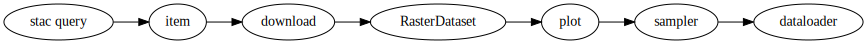

In [24]:
gv('"stac query"->item->download->RasterDataset->plot->sampler->dataloader')

In [1]:
# %env PROJ_LIB=/home/jovyan/local/lib/python3.10/site-packages/pyproj/proj_dir/share/proj
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

In [2]:
root = '/tmp/s2l2a'
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220902T090559_R050_T40XDH_20220902T181115",
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B02", "B03", "B04", "B08"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

  0%|          | 0/197389773 [00:00<?, ?it/s]

  0%|          | 0/192099728 [00:00<?, ?it/s]

  0%|          | 0/186117847 [00:00<?, ?it/s]

  0%|          | 0/185748811 [00:00<?, ?it/s]

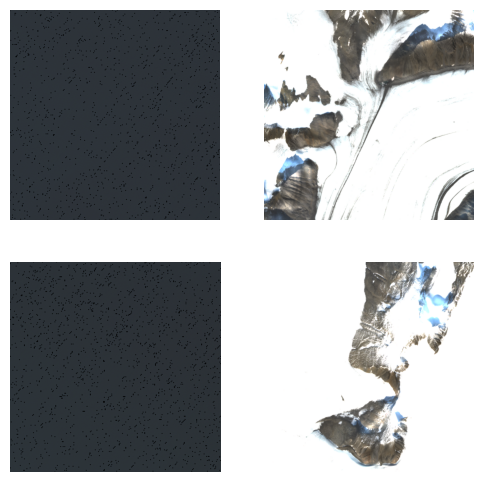

In [22]:
class Sentinel2(RasterDataset):
    filename_glob = "T*_B02_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

    def plot(self, sample, ax=[]):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1)

        # Plot the image
        if not ax:
            fig, ax = plt.subplots()
        ax.imshow(image)
        ax.axis("off")

        # return fig

dataset = Sentinel2(root)
sampler = RandomGeoSampler(dataset, size=512, length=4)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

fig, axs = plt.subplots(2, 2, figsize=(6,6))
for batch, ax in zip(dataloader, axs.ravel()):
    sample = unbind_samples(batch)[0]
    dataset.plot(sample, ax)